# Table of Content

1) Import the Libraries

2) Get the Data

3) Cleaning the Data

4) Categorical Features Analysis

5) Numerical Features Analysis

6) Cunclosion

7) Feature Importance and Selection

8) Split the Train and Test datasets

9) Prepering the Data

10) Models and Evaluation

11) Comparing Model Scores

## Import the Libraries

In [1]:
import numpy as np 
import scipy.stats as stats
import pandas as pd
pd.pandas.set_option('display.max_columns',None)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_predict,learning_curve
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import precision_score,recall_score, f1_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder , OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, chi2 ,f_classif
from sklearn.inspection import permutation_importance


from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

## Get the Data

In [2]:
heart=pd.read_csv('/kaggle/input/heart-failure-prediction/heart.csv')
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


## Cleaning the Data

In [3]:
heart_copy=heart.copy()
heart_copy.isnull().sum().sort_values(ascending=False)

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

## Categorical Features Analysis

In [4]:
#Let's find the categorical featuers
cat_features=[feature for feature in heart_copy.columns if heart_copy[feature].dtypes == object]
cat_features

['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

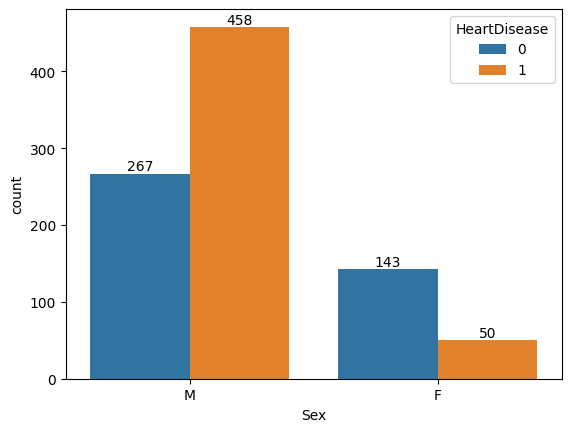

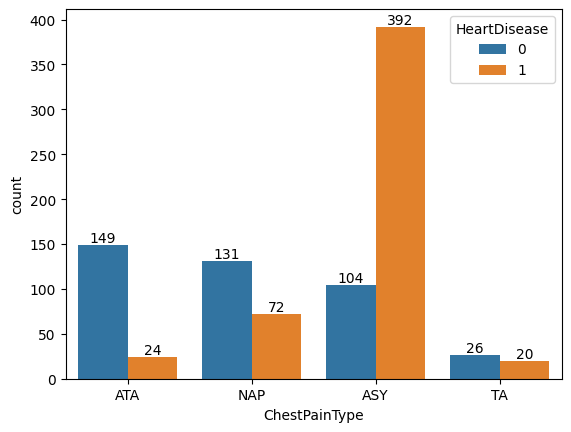

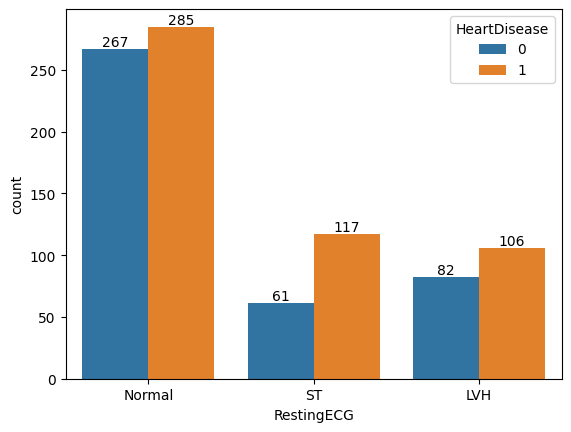

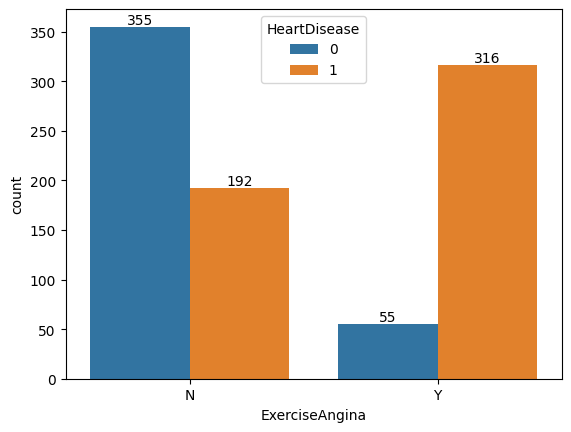

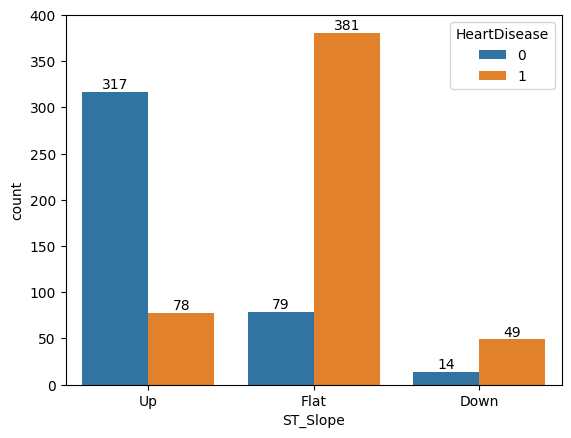

In [5]:
cat_df=pd.concat([heart_copy[cat_features],heart_copy['HeartDisease']],axis=1)
for index,predictor in enumerate(cat_df.drop(columns=['HeartDisease'])):
    plt.figure(index)
    ax=sns.countplot(data=cat_df,x=predictor,hue='HeartDisease')
    for container in ax.containers:
        ax.bar_label(container)

### Heart Disease Ratio Comparison Across Categorical Features

### 1. Gender
- **Male:** 63.17  
- **Female:** 25.90  

*Males show a significantly higher prevalence of heart disease compared to females.*

### 2. Chest Pain Type (Highest to Lowest)
- **ASY (Asymptomatic):** 79.03  
- **TA (Typical Angina):** 43.47  
- **NAP (Non-Anginal Pain):** 35.46  
- **ATA (Atypical Angina):** 13.87  

*Asymptomatic cases dominate, indicating many patients do not experience classic chest pain symptoms.*

### 3. Resting ECG Results (Highest to Lowest)
- **ST:** 65.73  
- **LVH (Left Ventricular Hypertrophy):** 56.38  
- **Normal:** 51.63  

*A high proportion of heart disease cases show abnormal ECG readings, particularly ST segment elevation.*

### 4. Exercise-Induced Angina
- **Yes:** 85.17  
- **No:** 19.74  

*Exercise-induced angina is strongly associated with heart disease.*

### 5. ST Slope (Highest to Lowest)
- **Flat:** 82.82  
- **Down:** 77.77  
- **Up:** 19.74  

*A flat ST slope is the most common among heart disease cases, followed by a downward slope.*


## Numerical Features Analysis

In [6]:
#First we go for Discrete  numerical features
dis_features=[feature for feature in heart_copy.columns if heart_copy[feature].dtypes!=object and heart_copy[feature].nunique()<10]
dis_features

['FastingBS', 'HeartDisease']

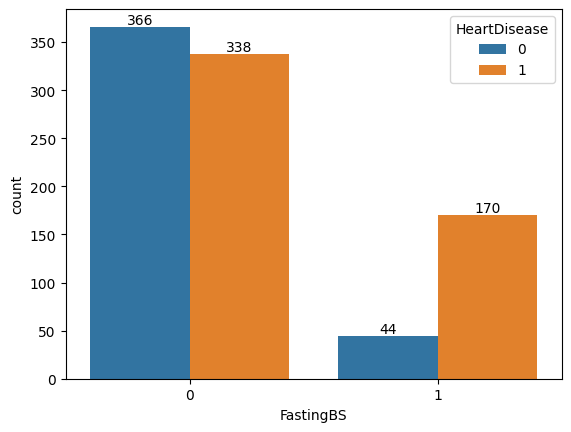

In [7]:
for index,predictor in enumerate(heart_copy[dis_features].drop(columns=['HeartDisease'])):
    plt.figure(index)
    ax=sns.countplot(data=heart_copy,x=predictor,hue='HeartDisease')
    for container in ax.containers:
        ax.bar_label(container)

### Heart Disease Ratio Comparison: Fasting Blood Sugar

### **Fasting Blood Sugar Levels**
- **1 (High Fasting Blood Sugar):** 79.43  
- **0 (Normal Fasting Blood Sugar):** 48.01  

*A higher fasting blood sugar level (≥ 126 mg/dL) is strongly associated with an increased likelihood of heart disease.*


In [8]:
#Know we go for continuous numerical features
conti_features=[feature for feature in heart_copy.columns if heart_copy[feature].dtypes!=object and feature not in dis_features]
conti_features

['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

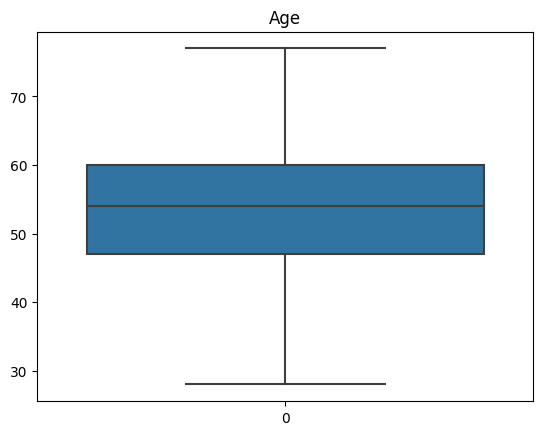

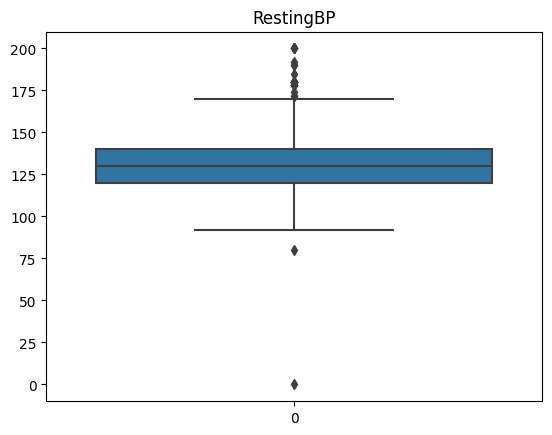

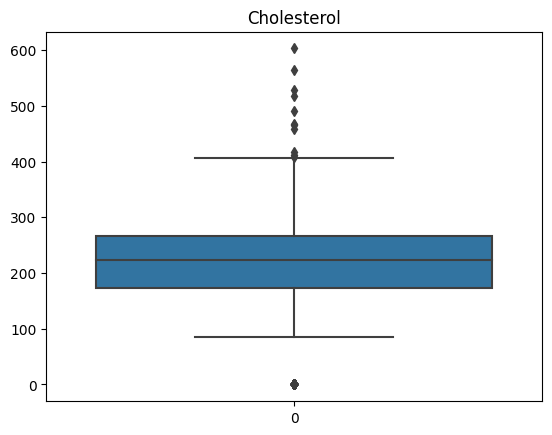

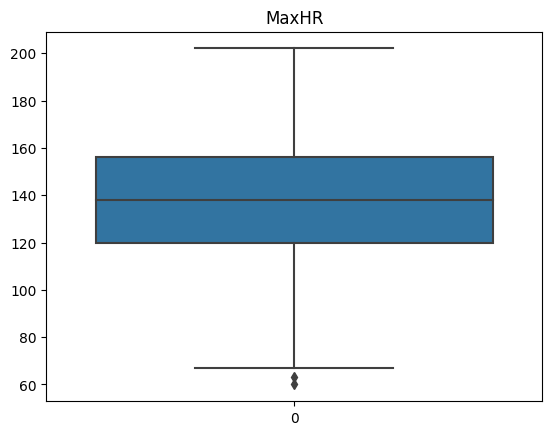

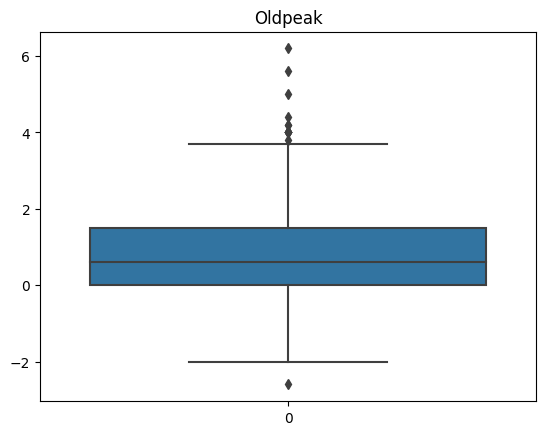

In [9]:
#Checking the outlayers and invalid data

for feature in conti_features:
    plt.figure()
    sns.boxplot(heart_copy[feature])
    plt.title(feature)

In [10]:
summary_df = heart_copy.describe().T.round(2)
summary_df

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.51,9.43,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.40,18.51,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.80,109.38,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.23,0.42,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.81,25.46,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.89,1.07,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.55,0.50,0.0,0.00,1.0,1.0,1.0


### **Data Validation and Cleaning Summary**

### **1. Age**
✅ No invalid data detected for Age.

### **2. Resting Blood Pressure (RestingBP)**
❌ Zero values are invalid, so they were replaced with **nulls** (`NaN`).

### **3. Cholesterol**
❌ **Zero values were identified**, but since a large portion of the dataset has this issue, further analysis was conducted separately.

### **4. Oldpeak**
✅ No invalid values detected.

---

### **Next Steps**
- Investigate the distribution of cholesterol values to determine the best approach for handling zeros.
- Explore imputation strategies for missing RestingBP values.
ferent segments of the dataset.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


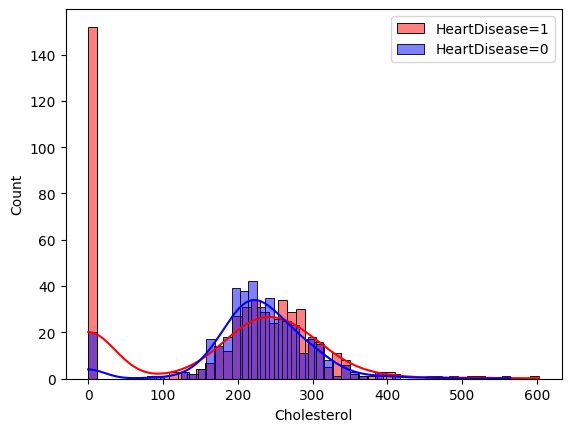

In [11]:
#Checking Cholesterol invalid zeros so we can check it's impact on the Heart Disease

heart_disease_0 = heart_copy[heart_copy['HeartDisease'] == 0]
heart_disease_1 = heart_copy[heart_copy['HeartDisease'] == 1]

sns.histplot(heart_disease_1['Cholesterol'], color='red', label='HeartDisease=1', kde=True,bins=50)
sns.histplot(heart_disease_0['Cholesterol'], color='blue', label='HeartDisease=0', kde=True,bins=50)
plt.legend()
plt.show()

### **Cholesterol Data Issue**
### **Observation**
We detected a significantly higher number of **zero values** in cholesterol among heart disease patients. This suggests that these zeros might not be truly missing, but could **represent high cholesterol values** that were incorrectly recorded.


In [12]:
#Predicting the missing values of Cholesterol with knnImputer
encoder = OneHotEncoder(handle_unknown='ignore')

features = ['Sex', 'ExerciseAngina', 'ChestPainType', 'RestingECG', 'ST_Slope']
cat_encoded = encoder.fit_transform(heart_copy[features])
cat_encoded = pd.DataFrame(cat_encoded.toarray(), columns=encoder.get_feature_names_out(), index=heart_copy.index)  
df_encoded = pd.concat([heart_copy.drop(columns=features), cat_encoded], axis=1) 


knn_imputer = KNNImputer(n_neighbors=5)

df_encoded['Cholesterol'] = df_encoded['Cholesterol'].replace(0,np.nan)

df_encoded['Cholesterol']=knn_imputer.fit_transform(df_encoded)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


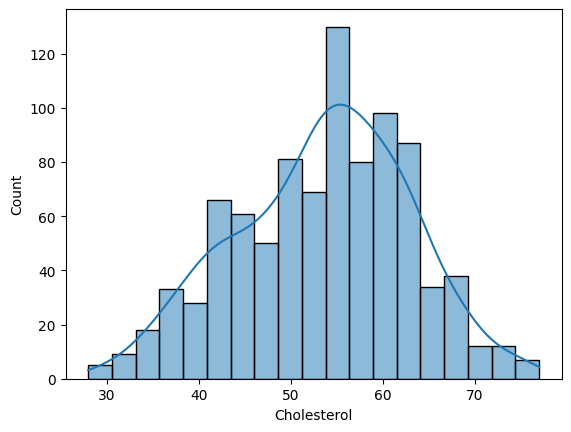

In [13]:
#Let's plot the cholesetor again and see the changes
plt.figure()
sns.histplot(df_encoded['Cholesterol'],kde=True)
plt.show()

In [14]:
conti_corr=heart_copy[conti_features].corrwith(heart_copy['HeartDisease'])
conti_corr.sort_values(ascending=False)

Oldpeak        0.403951
Age            0.282039
RestingBP      0.107589
Cholesterol   -0.232741
MaxHR         -0.400421
dtype: float64

As this is obviouse the **Oldpeak** has a stronge possetive correlation with the result and **Cholesterol** has a stronge negative correlation

In [15]:
#Let's check for skewness in the data

for i in conti_features:
    print(f"{i}:{df_encoded[i].skew()}")

Age:-0.19593302867569365
RestingBP:0.17983931005162884
Cholesterol:-0.19593302867569365
MaxHR:-0.14435941846181
Oldpeak:1.0228720218107528


The **Oldpeak** feature exhibits moderate skewness, which may impact the performance of machine learning models. Proper transformation is needed to ensure better model stability and accuracy.

## Feature Importance and Selection

In [16]:
# Apply Chi-Squared test
cat_encoded_features=[i for i in df_encoded.columns if df_encoded[i].nunique()<10]

X = df_encoded[cat_encoded_features]  
y = df_encoded['HeartDisease']  

chi2_selector = SelectKBest(score_func=chi2, k='all')  
X_selected = chi2_selector.fit_transform(X, y)

scores = chi2_selector.scores_
feature_scores = pd.DataFrame({'Feature': X.columns, 'Chi2 Score': scores})
feature_scores = feature_scores.sort_values(by='Chi2 Score', ascending=False)

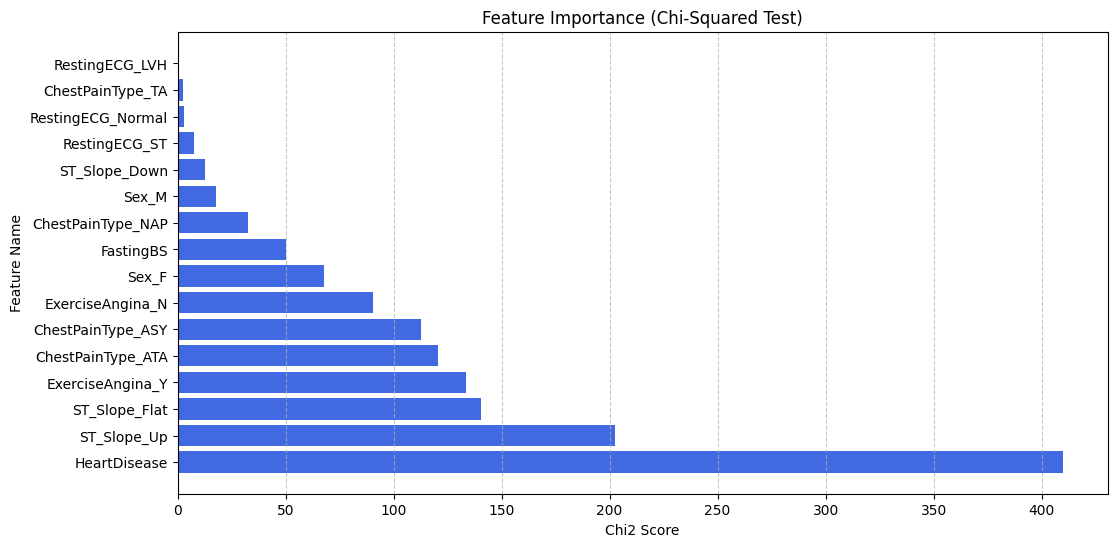

In [17]:
plt.figure(figsize=(12, 6))
plt.barh(feature_scores['Feature'], feature_scores['Chi2 Score'], color='royalblue')
plt.xlabel('Chi2 Score')
plt.ylabel('Feature Name')
plt.title('Feature Importance (Chi-Squared Test)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [18]:
#ANOVA test
num_encoded_features=[i for i in df_encoded.columns if df_encoded[i].nunique()>10]


X = df_encoded[num_encoded_features]  
y = heart_copy['HeartDisease']  

anova_selector = SelectKBest(score_func=f_classif, k='all')  
X_selected = anova_selector.fit_transform(X, y)

scores = anova_selector.scores_
feature_scores = pd.DataFrame({'Feature': X.columns, 'ANOVA Score': scores})
feature_scores=feature_scores.sort_values(by='ANOVA Score',ascending=True)


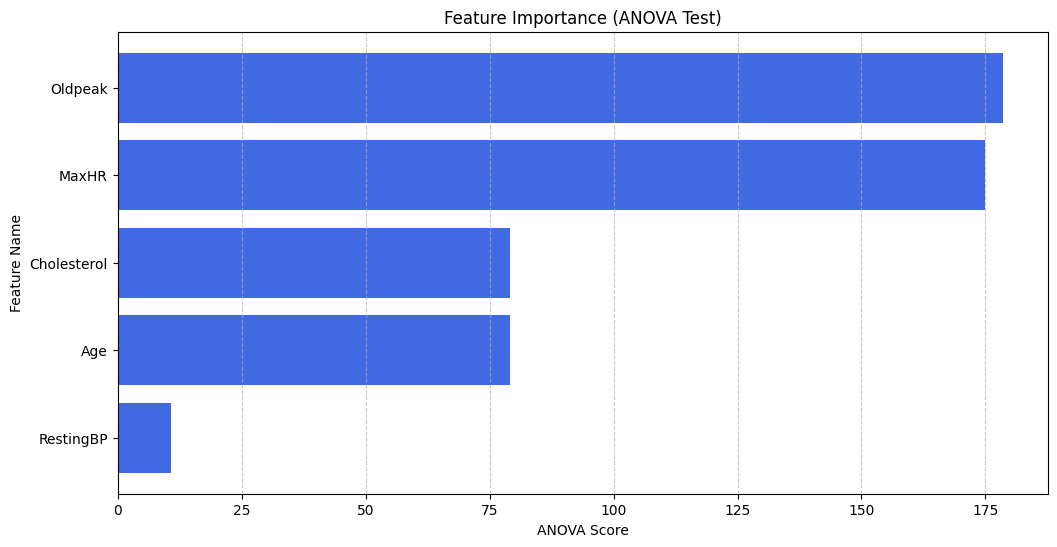

In [19]:
plt.figure(figsize=(12, 6))
plt.barh(feature_scores['Feature'], feature_scores['ANOVA Score'], color='royalblue')
plt.xlabel('ANOVA Score')
plt.ylabel('Feature Name')
plt.title('Feature Importance (ANOVA Test)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [20]:
#Permutation importance using random forest
X=df_encoded.drop(columns=['HeartDisease'])
y=df_encoded['HeartDisease']
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X, y)

feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': rnd_clf.feature_importances_})

feature_importances = feature_importances.sort_values(by='Importance', ascending=False)


perm_importance = permutation_importance(rnd_clf, X, y, scoring='f1')

perm_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': perm_importance.importances_mean})
perm_importance_df = perm_importance_df.sort_values(by='Importance', ascending=False)

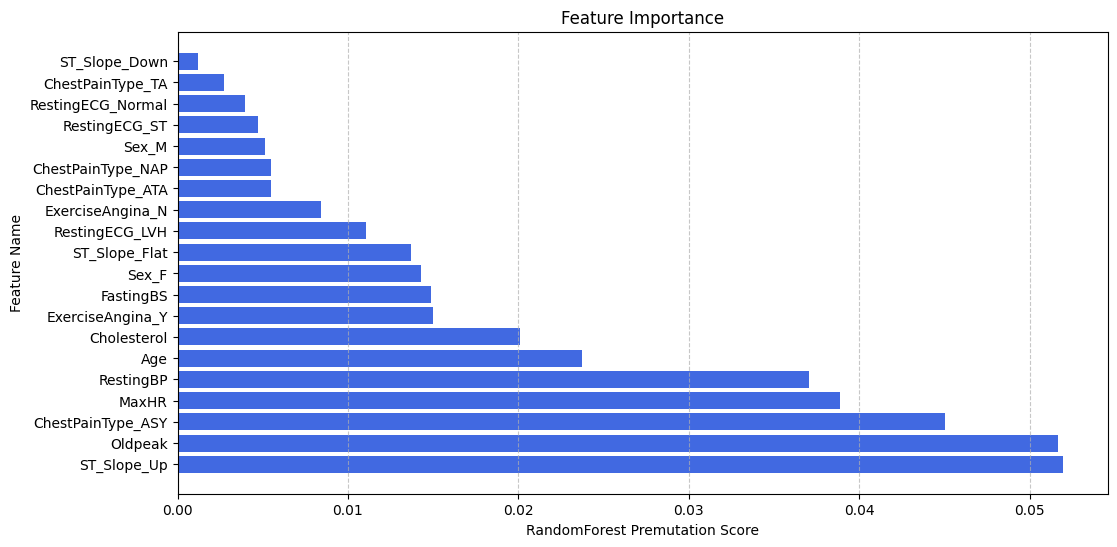

In [21]:
plt.figure(figsize=(12, 6))
plt.barh(perm_importance_df['Feature'], perm_importance_df['Importance'], color='royalblue')
plt.xlabel('RandomForest Premutation Score')
plt.ylabel('Feature Name')
plt.title('Feature Importance')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

According to above tests I decide to drop  **RestingECG** and **RestingBP**

## Cunclosion

From our investigation into heart disease prevalence across categorical features, several key patterns emerged:

1. **Gender Disparity**  
   - Males exhibit a significantly higher ratio of heart disease compared to females, highlighting potential biological or lifestyle-related risk factors.
     
     

2. **Chest Pain Type Significance**  
   - Asymptomatic cases dominate the dataset, suggesting that many patients do not experience traditional chest pain symptoms, which could delay diagnosis.

3. **ECG & Exercise-Induced Angina**  
   - Abnormal ECG readings and exercise-induced angina show strong associations with heart disease, reinforcing the importance of stress testing in early detection.

4. **ST Slope & Oldpeak Correlation**  
   - A flat ST slope and high Oldpeak values appear strongly linked to heart disease, demonstrating the predictive power of exercise-induced ST segment changes.

5. **Fasting Blood Sugar & Cholesterol**  
   - High fasting blood sugar levels show a clear correlation with heart disease, while cholesterol patterns require further investigation due to the high presence of recorded zero values.

In [22]:
heart_copy['RestingBP']=heart_copy['RestingBP'].replace(0,np.nan)

#Since the RestingBP has only one null value it's better to delete it  
heart_copy.dropna(subset=['RestingBP'],inplace=True)

#I replace invalid 0 values in 'Cholesterol' so I can handle it later using pipelines
heart_copy['Cholesterol'] = heart_copy['Cholesterol'].replace(0,np.nan) 

## Split the Train and Test datasets

In [23]:
X,y=heart_copy.drop(columns=['HeartDisease']),heart_copy['HeartDisease'].copy()
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

## Prepering the Data

In [24]:
categorical_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

num_transformer = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)


numeric_features = ['Age', 'MaxHR', 'Oldpeak', 'Cholesterol']
categorical_features = ['Sex', 'ChestPainType', 'ExerciseAngina', 'ST_Slope']
all=numeric_features+categorical_features


preprocessor = ColumnTransformer([
    ('cat', categorical_transformer, categorical_features),  
    ('num', num_transformer, numeric_features),
], remainder='drop')

preprocessor_pipe=make_pipeline(
    preprocessor,
    KNNImputer(n_neighbors=5)
)

X_transformed = preprocessor_pipe.fit_transform(heart_copy)

In [25]:
X_transformed = pd.DataFrame(X_transformed,columns=preprocessor.get_feature_names_out(),index=heart_copy.index)
X_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 917 entries, 0 to 917
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   cat__Sex_F              917 non-null    float64
 1   cat__Sex_M              917 non-null    float64
 2   cat__ChestPainType_ASY  917 non-null    float64
 3   cat__ChestPainType_ATA  917 non-null    float64
 4   cat__ChestPainType_NAP  917 non-null    float64
 5   cat__ChestPainType_TA   917 non-null    float64
 6   cat__ExerciseAngina_N   917 non-null    float64
 7   cat__ExerciseAngina_Y   917 non-null    float64
 8   cat__ST_Slope_Down      917 non-null    float64
 9   cat__ST_Slope_Flat      917 non-null    float64
 10  cat__ST_Slope_Up        917 non-null    float64
 11  num__Age                917 non-null    float64
 12  num__MaxHR              917 non-null    float64
 13  num__Oldpeak            917 non-null    float64
 14  num__Cholesterol        917 non-null    float64

## Models and Evaluation

In [26]:
#SGDClassifier:
sgd_clf=make_pipeline(preprocessor_pipe,SGDClassifier(random_state=42))

#sgd_clf tuning
param_grid = {
    'sgdclassifier__alpha': [0.0001, 0.001, 0.01, 0.1],
    'sgdclassifier__penalty': ['l2', 'l1', 'elasticnet'],
    'sgdclassifier__max_iter': [1000, 2000, 3000]
}

grid_search = GridSearchCV(sgd_clf, param_grid, cv=10, scoring='f1', n_jobs=-1,verbose=1)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {np.round(grid_search.best_score_ * 100 , 2)}")

Fitting 10 folds for each of 36 candidates, totalling 360 fits
Best parameters: {'sgdclassifier__alpha': 0.001, 'sgdclassifier__max_iter': 1000, 'sgdclassifier__penalty': 'elasticnet'}
Best score: 86.65


In [27]:
sgd_clf.set_params(**grid_search.best_params_)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('cat',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['Sex',
                                                                    'ChestPainType',
                                                                    'ExerciseAngina',
                                                                    'ST_Slope']),
                                                                  ('num',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('standardscaler',
                                                                                    StandardScaler())]),
                                                                   ['Age',
                                                                    'MaxHR',
                                                                    'Oldpeak',
                                                                    'Cholesterol'])])),
                                 ('knnimputer', KNNImputer())])),
                ('sgdclassifier',
                 SGDClassifier(alpha=0.001, penalty='elasticnet',
                               random_state=42))])

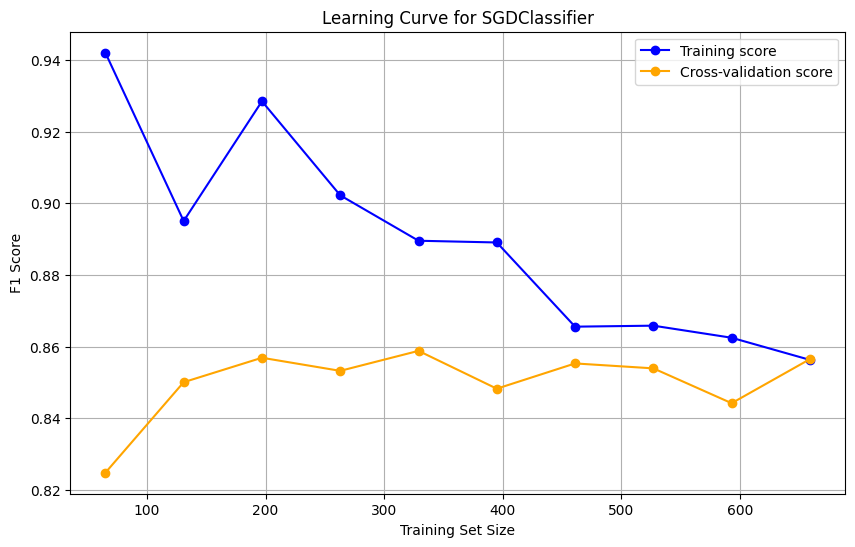

In [28]:
#Creating learning curve
train_sizes, train_scores, test_scores = learning_curve(
    sgd_clf, X_train, y_train, cv=10, scoring='f1', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue', marker='o')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score', color='orange', marker='o')

plt.title('Learning Curve for SGDClassifier')
plt.xlabel('Training Set Size')
plt.ylabel('F1 Score')
plt.legend()
plt.grid()
plt.show()

In [29]:
#Creating knn_clf
knn_clf=make_pipeline(
    preprocessor_pipe,
    KNeighborsClassifier()
)

#Tune the knn_model hyperparameters

param_grid = {
    'kneighborsclassifier__n_neighbors': range(1, 21),  
    'kneighborsclassifier__weights': ['uniform', 'distance'],  
    'kneighborsclassifier__metric': ['euclidean', 'manhattan', 'minkowski']  
}




grid_search = GridSearchCV(knn_clf, param_grid, cv=10, scoring='f1', n_jobs=-1,verbose=1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", np.round(grid_search.best_score_ * 100 ,2))

Fitting 10 folds for each of 120 candidates, totalling 1200 fits
Best parameters: {'kneighborsclassifier__metric': 'manhattan', 'kneighborsclassifier__n_neighbors': 19, 'kneighborsclassifier__weights': 'uniform'}
Best accuracy: 87.55


In [30]:
# Update the Knn_clf model with the best parameters
knn_clf.set_params(**grid_search.best_params_)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('cat',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['Sex',
                                                                    'ChestPainType',
                                                                    'ExerciseAngina',
                                                                    'ST_Slope']),
                                                                  ('num',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('standardscaler',
                                                                                    StandardScaler())]),
                                                                   ['Age',
                                                                    'MaxHR',
                                                                    'Oldpeak',
                                                                    'Cholesterol'])])),
                                 ('knnimputer', KNNImputer())])),
                ('kneighborsclassifier',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=19))])

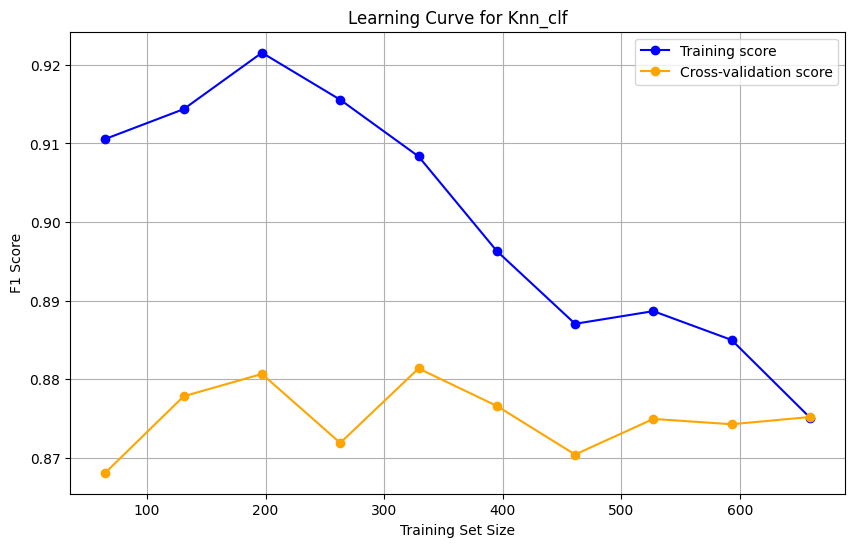

In [31]:
#Creating learning curve
train_sizes, train_scores, test_scores = learning_curve(
    knn_clf, X_train, y_train, cv=10, scoring='f1', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue', marker='o')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score', color='orange', marker='o')

plt.title('Learning Curve for Knn_clf')
plt.xlabel('Training Set Size')
plt.ylabel('F1 Score')
plt.legend()
plt.grid()
plt.show()

In [32]:
#Creating the GuassianNB_clf model
GaussianNB_clf=make_pipeline(
    preprocessor_pipe,
    GaussianNB()
)

#Tune the GuassianNB_clf hyperparameters
param_grid = {'gaussiannb__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}

grid_search = GridSearchCV(GaussianNB_clf, param_grid, cv=10, scoring='f1')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", np.round(grid_search.best_score_ * 100,2))

Best parameters: {'gaussiannb__var_smoothing': 1e-09}
Best accuracy: 85.92


In [33]:
# Update the GaussianNB_clf model with the best parameters
GaussianNB_clf.set_params(**grid_search.best_params_)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('cat',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['Sex',
                                                                    'ChestPainType',
                                                                    'ExerciseAngina',
                                                                    'ST_Slope']),
                                                                  ('num',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('standardscaler',
                                                                                    StandardScaler())]),
                                                                   ['Age',
                                                                    'MaxHR',
                                                                    'Oldpeak',
                                                                    'Cholesterol'])])),
                                 ('knnimputer', KNNImputer())])),
                ('gaussiannb', GaussianNB())])

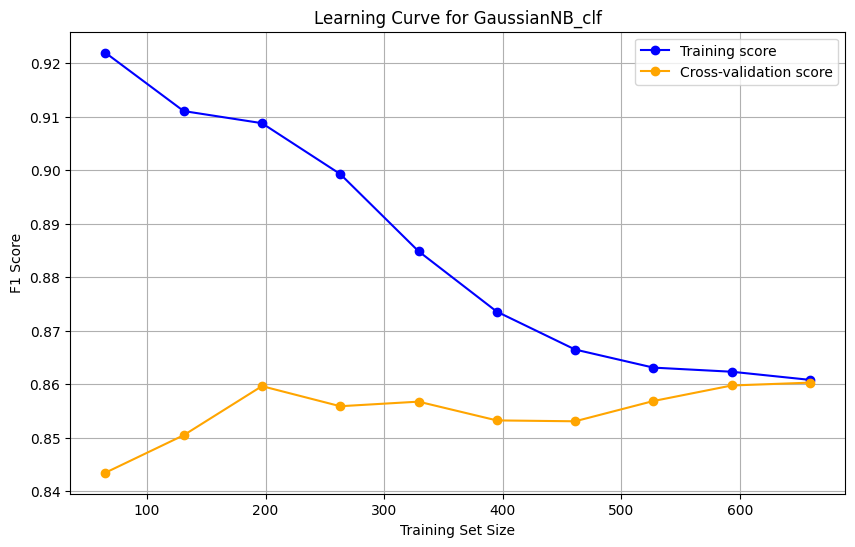

In [34]:
#Creating learning curve
train_sizes, train_scores, test_scores = learning_curve(
    GaussianNB_clf, X_train, y_train, cv=10, scoring='f1', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue', marker='o')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score', color='orange', marker='o')

plt.title('Learning Curve for GaussianNB_clf')
plt.xlabel('Training Set Size')
plt.ylabel('F1 Score')
plt.legend()
plt.grid()
plt.show()

In [35]:
#Creating SVC model
svc_clf=make_pipeline(
    preprocessor_pipe,
    SVC(random_state=42)
)

#Tuning SVC classifier hyperparameters

param_grid = {
    'svc__C': [0.1, 1, 10],  
    'svc__kernel': ['poly', 'rbf','linear'],  
    'svc__gamma': ['scale', 'auto'],  
    'svc__degree': [2, 3]  
}

grid_search = GridSearchCV(svc_clf, param_grid, cv=10, scoring='f1', n_jobs=-1,verbose=1)
grid_search.fit(X_train, y_train)  

print("Best Parameters:", grid_search.best_params_)
print("Best f1:", np.round(grid_search.best_score_ * 100 , 2))


Fitting 10 folds for each of 36 candidates, totalling 360 fits
Best Parameters: {'svc__C': 0.1, 'svc__degree': 3, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}
Best f1: 87.4


In [36]:
# Update the SVC model with the best parameters
svc_clf.set_params(**grid_search.best_params_)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('cat',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['Sex',
                                                                    'ChestPainType',
                                                                    'ExerciseAngina',
                                                                    'ST_Slope']),
                                                                  ('num',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('standardscaler',
                                                                                    StandardScaler())]),
                                                                   ['Age',
                                                                    'MaxHR',
                                                                    'Oldpeak',
                                                                    'Cholesterol'])])),
                                 ('knnimputer', KNNImputer())])),
                ('svc', SVC(C=0.1, kernel='poly', random_state=42))])

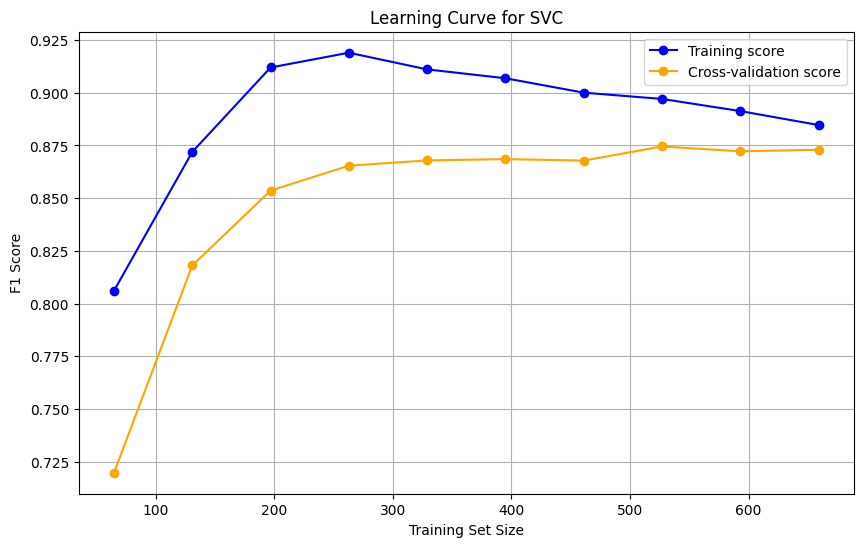

In [37]:
#Creating learning curve for SVC model
train_sizes, train_scores, test_scores = learning_curve(
    svc_clf, X_train, y_train, cv=10, scoring='f1', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue', marker='o')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score', color='orange', marker='o')

plt.title('Learning Curve for SVC')
plt.xlabel('Training Set Size')
plt.ylabel('F1 Score')
plt.legend()
plt.grid()
plt.show()

In [38]:
#Creating DecisionTreeClassifier
dt_clf=make_pipeline(
    preprocessor_pipe,
    DecisionTreeClassifier(random_state=42)
)

# Hyperparameter tuning for DecisionTreeClassifier
param_grid = {
    'decisiontreeclassifier__max_depth': [None,5, 10, 20],
    'decisiontreeclassifier__min_samples_split': [5, 10,20],
    'decisiontreeclassifier__min_samples_leaf': [ 2, 4,8],
    'decisiontreeclassifier__criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(dt_clf, param_grid, cv=10, scoring='f1', n_jobs=-1,verbose=1)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {np.round(grid_search.best_score_ * 100,2)}")

Fitting 10 folds for each of 72 candidates, totalling 720 fits
Best parameters: {'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': None, 'decisiontreeclassifier__min_samples_leaf': 8, 'decisiontreeclassifier__min_samples_split': 20}
Best score: 84.52


In [39]:
#Updating the DecisionTreeClassifier with best parameters
dt_clf.set_params(**grid_search.best_params_)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('cat',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['Sex',
                                                                    'ChestPainType',
                                                                    'ExerciseAngina',
                                                                    'ST_Slope']),
                                                                  ('num',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('standardscaler',
                                                                                    StandardScaler())]),
                                                                   ['Age',
                                                                    'MaxHR',
                                                                    'Oldpeak',
                                                                    'Cholesterol'])])),
                                 ('knnimputer', KNNImputer())])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(min_samples_leaf=8,
                                        min_samples_split=20,
                                        random_state=42))])

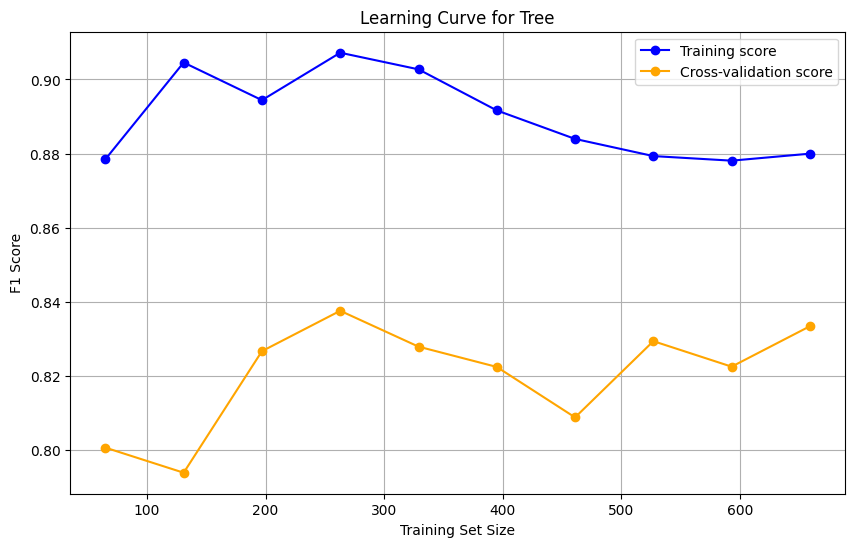

In [40]:
#Creating the learning curve for DecisionTreeClassifier
train_sizes, train_scores, test_scores = learning_curve(
    dt_clf, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue', marker='o')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score', color='orange', marker='o')

plt.title('Learning Curve for Tree')
plt.xlabel('Training Set Size')
plt.ylabel('F1 Score')
plt.legend()
plt.grid()
plt.show()

In [41]:
#Create RandomForestClassifier model
rnd_clf=make_pipeline(
    preprocessor_pipe,
    RandomForestClassifier(random_state=42)
)

#Tune the rnd_clf hyperparameters
param_grid = {
    'randomforestclassifier__n_estimators': [50, 100, 200],
    'randomforestclassifier__max_depth': [None, 10, 20, 30],
    'randomforestclassifier__min_samples_split': [2, 5, 10],
    'randomforestclassifier__min_samples_leaf': [1, 2, 4]
}

# Perform grid search
grid_search = GridSearchCV(rnd_clf, param_grid, cv=10, scoring='f1', n_jobs=-1,verbose=2)
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {np.round(grid_search.best_score_ * 100,2)}")

Fitting 10 folds for each of 108 candidates, totalling 1080 fits
Best parameters: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__n_estimators': 100}
Best score: 87.59


In [42]:
#Updating the rnd_clf with best parameters
rnd_clf.set_params(**grid_search.best_params_)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('cat',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['Sex',
                                                                    'ChestPainType',
                                                                    'ExerciseAngina',
                                                                    'ST_Slope']),
                                                                  ('num',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('standardscaler',
                                                                                    StandardScaler())]),
                                                                   ['Age',
                                                                    'MaxHR',
                                                                    'Oldpeak',
                                                                    'Cholesterol'])])),
                                 ('knnimputer', KNNImputer())])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=4,
                                        min_samples_split=10,
                                        random_state=42))])

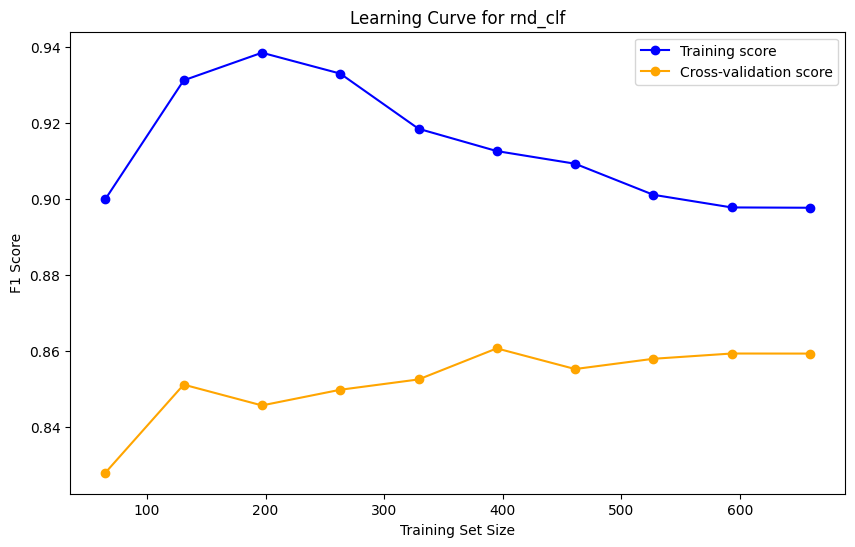

In [43]:
#Creating the learning curve for rnd_clf
train_sizes, train_scores, test_scores = learning_curve(
    rnd_clf, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue', marker='o')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score', color='orange', marker='o')

plt.title('Learning Curve for rnd_clf')
plt.xlabel('Training Set Size')
plt.ylabel('F1 Score')
plt.legend()

## Comparing Model Scores

In [44]:
sgd_predicts=cross_val_predict(sgd_clf,X_train,y_train,cv=10)
knn_predicts=cross_val_predict(knn_clf,X_train,y_train,cv=10)
GaussianNB_predicts=cross_val_predict(GaussianNB_clf,X_train,y_train,cv=10)
dt_predicts=cross_val_predict(dt_clf,X_train,y_train,cv=10)
rnd_predicts=cross_val_predict(rnd_clf,X_train,y_train,cv=10)

#sgd_scores
sgd_clf_f1=f1_score(y_train,sgd_predicts)
sgd_clf_precision=precision_score(y_train,sgd_predicts)
sgd_clf_recall=recall_score(y_train,sgd_predicts)

#knn_scores
knn_clf_f1=f1_score(y_train,knn_predicts)
knn_clf_precision=precision_score(y_train,knn_predicts)
knn_clf_recall=recall_score(y_train,knn_predicts)

#GuassianNB_scores
GaussianNB_clf_f1=f1_score(y_train,GaussianNB_predicts)
GaussianNB_clf_precision=precision_score(y_train,GaussianNB_predicts)
GaussianNB_clf_recall=recall_score(y_train,GaussianNB_predicts)

#df_scores
dt_clf_f1=f1_score(y_train,dt_predicts)
dt_clf_precision=precision_score(y_train,dt_predicts)
dt_clf_recall=recall_score(y_train,dt_predicts)

#rnd_scores
rnd_clf_f1=f1_score(y_train,rnd_predicts)
rnd_clf_precision=precision_score(y_train,rnd_predicts)
rnd_clf_recall=recall_score(y_train,rnd_predicts)



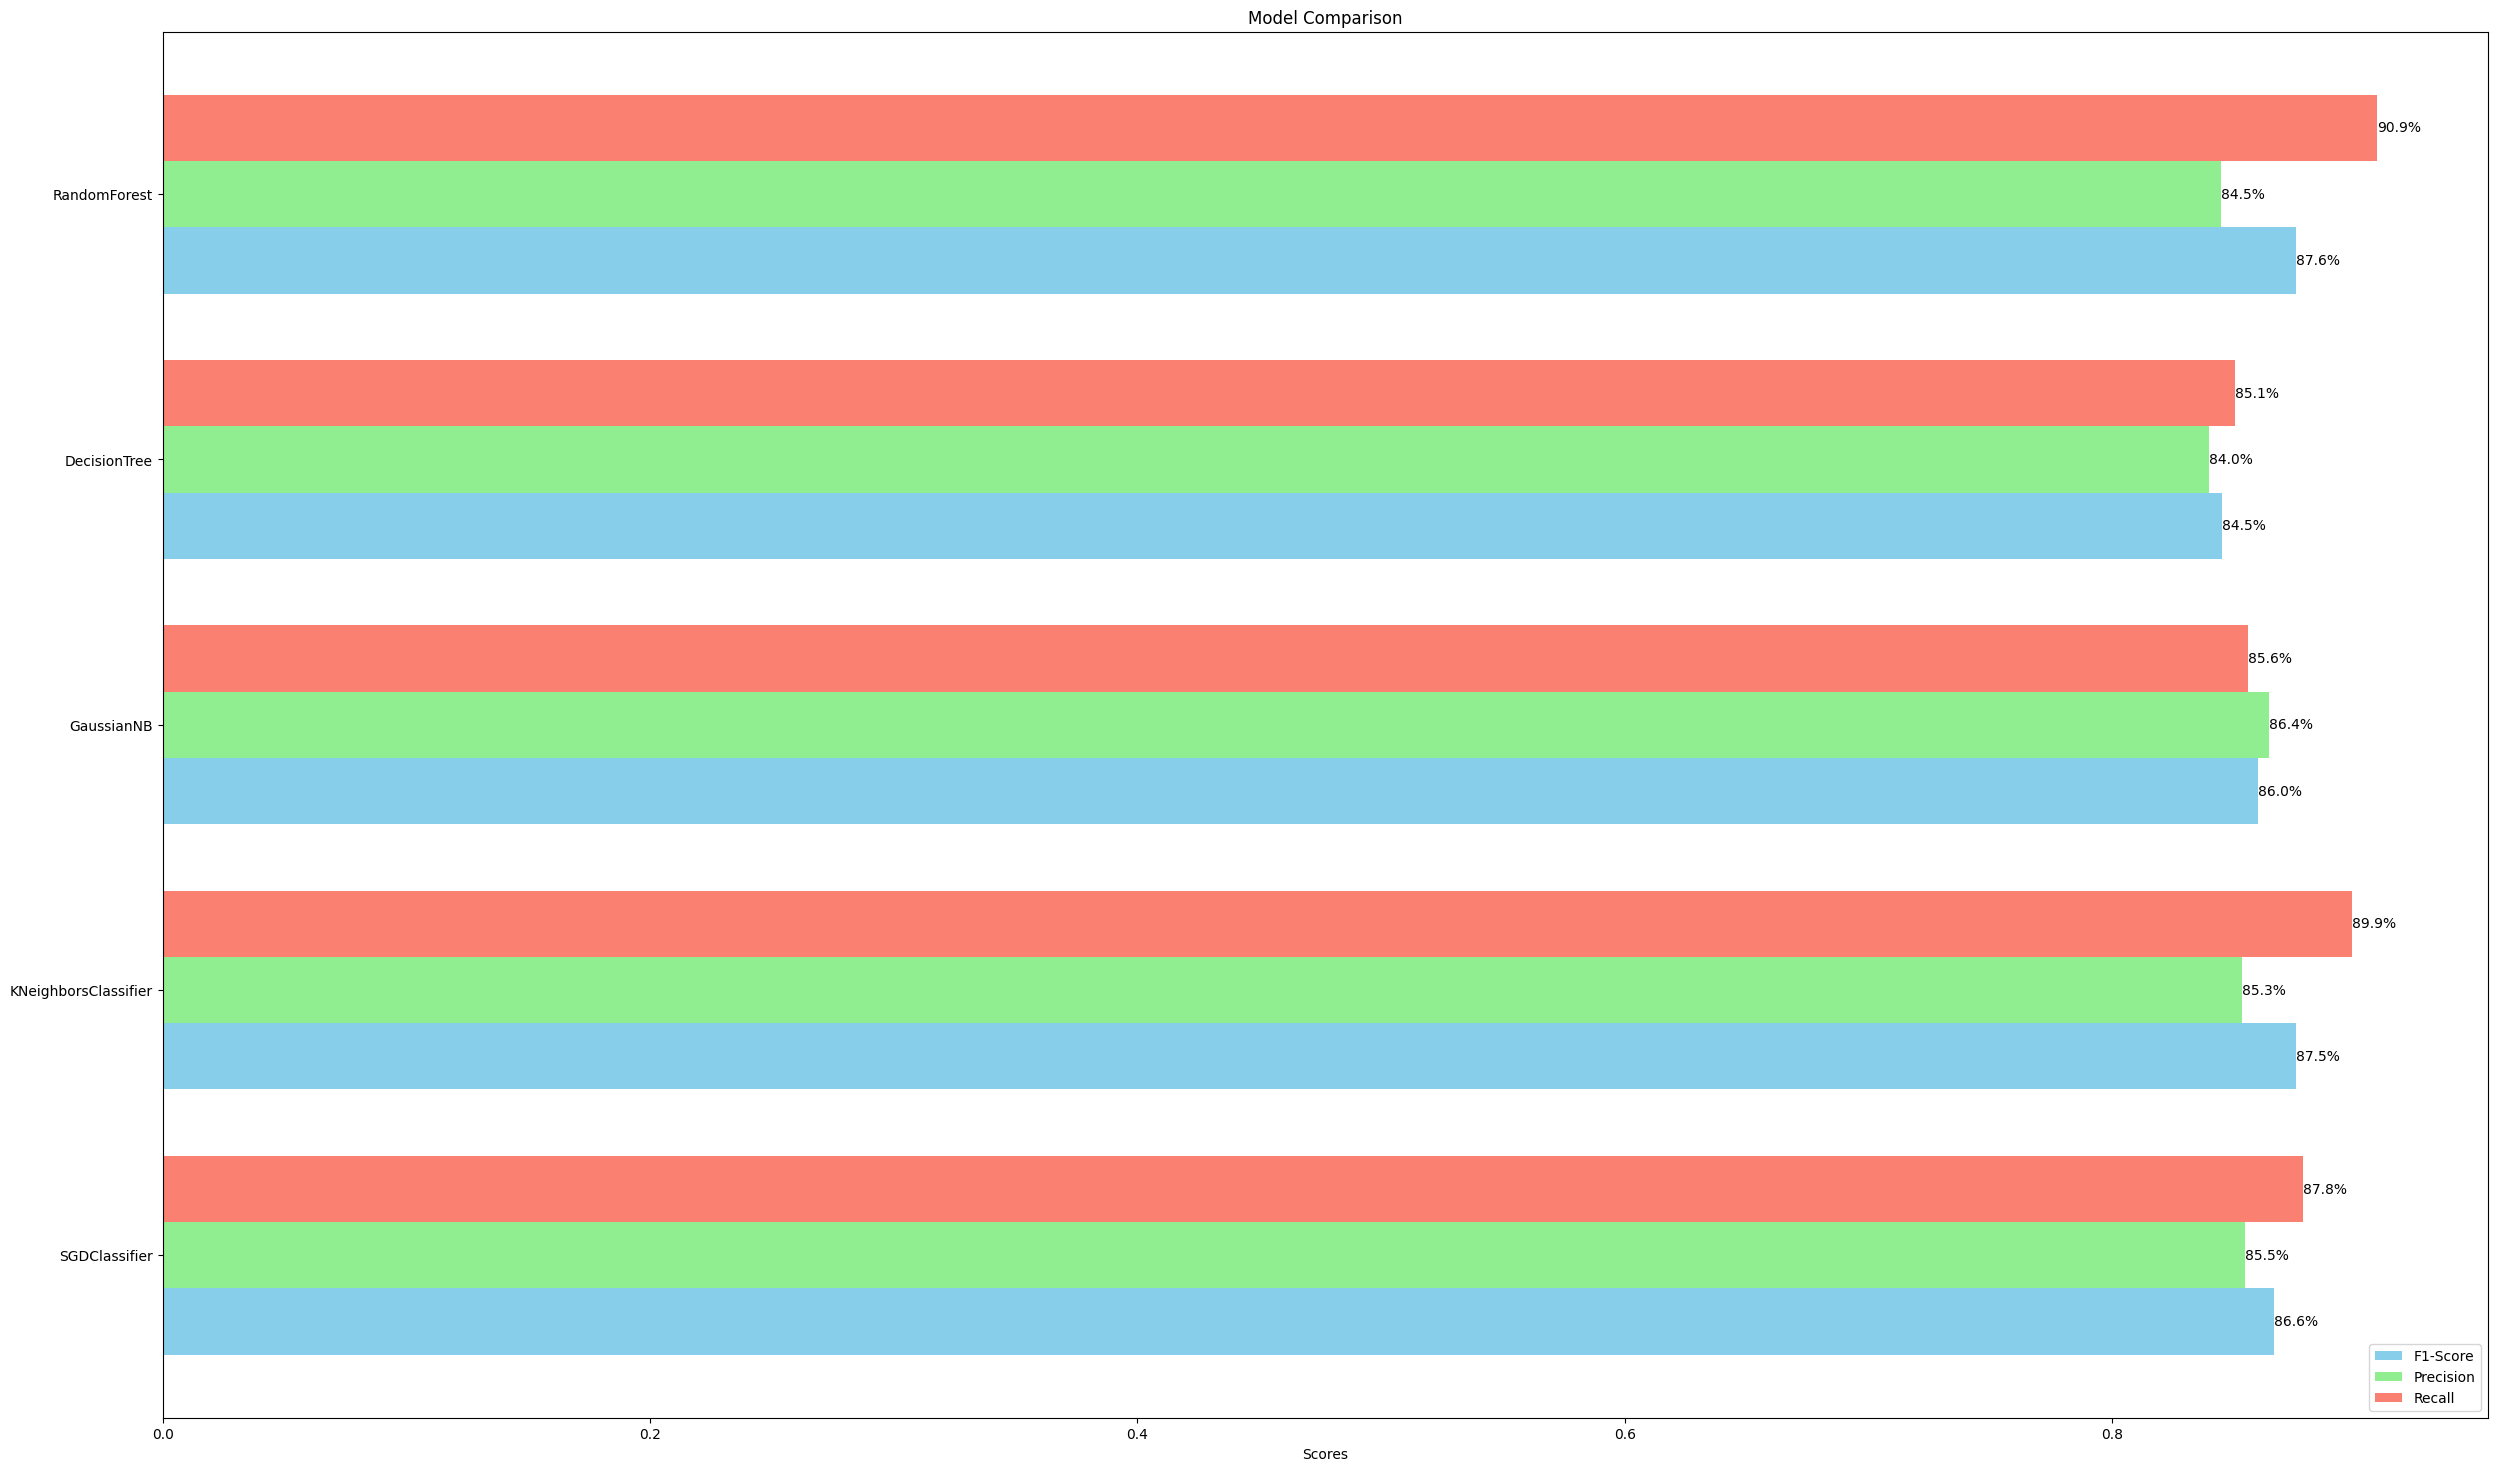

In [45]:
#Ploting scores results to compare all models
models = ['SGDClassifier','KNeighborsClassifier','GaussianNB', 'DecisionTree', 'RandomForest']
f1_scores = [sgd_clf_f1,knn_clf_f1,GaussianNB_clf_f1, dt_clf_f1, rnd_clf_f1]
precision_scores = [sgd_clf_precision,knn_clf_precision, GaussianNB_clf_precision,dt_clf_precision, rnd_clf_precision]
recall_scores = [sgd_clf_recall,knn_clf_recall,GaussianNB_clf_recall, dt_clf_recall, rnd_clf_recall]

# Create a horizontal bar plot
fig, ax = plt.subplots(figsize=(30, 18))
bar_width = 0.25
x = np.arange(len(models))

# Plot F1-scores, precision, and recall
ax.barh(x - bar_width, f1_scores, bar_width, label='F1-Score', color='skyblue')
ax.barh(x, precision_scores, bar_width, label='Precision', color='lightgreen')
ax.barh(x + bar_width, recall_scores, bar_width, label='Recall', color='salmon')

ax.set_yticks(x)    
ax.set_yticklabels(models)
ax.set_xlabel('Scores')
ax.set_title('Model Comparison')
ax.legend()

# Add percentage labels to each bar
for i, (f1, precision, recall) in enumerate(zip(f1_scores, precision_scores, recall_scores)):
    ax.text(f1, i - bar_width, f'{f1 * 100:.1f}%',va='center',ha='left',fontsize=10)
    ax.text(precision, i, f'{precision * 100:.1f}%',va='center',ha='left',fontsize=10)
    ax.text(recall, i + bar_width, f'{recall * 100:.1f}%',va='center',ha='left',fontsize=10)
plt.show()

From above results **rnd_clf** and **KneighborsClassifier** has the best results so I validate them both on test data

In [46]:
rnd_clf.fit(X_train,y_train)
knn_clf.fit(X_train,y_train)

rnd_test_predict=rnd_clf.predict(X_test)
knn_test_predict=knn_clf.predict(X_test)

rnd_test_f1=f1_score(y_test,rnd_test_predict)
knn_test_f1=f1_score(y_test,knn_test_predict)

print(f'rnd_clf f1 score on test data: {np.round(rnd_test_f1*100,3)}')
print(f'knn_clf f1 score on test data: {np.round(knn_test_f1*100,3)}')

rnd_clf f1 score on test data: 87.783
knn_clf f1 score on test data: 87.558


So as we see the best model is **rnd_clf**